In [ ]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=d68f1b495e79e0f52a5475e4a732ad6aef60ac2474f55542a0667eb348aa7335
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Download 100%.


In [ ]:
!signate download -c 1088

user.csv

card.csv

sample_submit.csv

test.csv

train.csv


Download completed.


In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight
from geopy.geocoders import Nominatim
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import optuna


# 列の制限を増やす
pd.set_option('display.max_columns', 300)

In [ ]:
# データの読み込み
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
card_data = pd.read_csv('card.csv')
user_data = pd.read_csv('user.csv')

# データの結合
train_data = train_data.merge(card_data, on=['user_id', 'card_id'], how='left')
train_data = train_data.merge(user_data, on='user_id', how='left')

test_data = test_data.merge(card_data, on=['user_id', 'card_id'], how='left')
test_data = test_data.merge(user_data, on='user_id', how='left')

## データの前処理・特徴量エンジニアリング

In [ ]:
submit_id = 18

# 数値データ型に変換
numerical_columns = ['amount', 'credit_limit', 'per_capita_income_zipcode', 'yearly_income_person', 'total_debt']

for column in numerical_columns:
    train_data[column] = train_data[column].str.replace('$', '').str.replace(',', '').astype(float)
    test_data[column] = test_data[column].str.replace('$', '').str.replace(',', '').astype(float)


# --------------------------------------------------------------------------------
# merchant_state == NaN -> merchant_city == ONLINE
# zip == NaN -> merchant_city == ONLINE or アメリカ国外
# --------------------------------------------------------------------------------

# "is_online"と"is_foreign"カラムを0で初期化
train_data['is_online'] = 0
train_data['is_foreign'] = 0
test_data['is_online'] = 0
test_data['is_foreign'] = 0

# 条件に合致する行に対してフラグを設定
mask_online = (train_data['zip'].isna()) & (train_data['merchant_city'] == 'ONLINE')
mask_foreign = (train_data['zip'].isna()) & (train_data['merchant_city'] != 'ONLINE')

train_data.loc[mask_online, 'is_online'] = 1
train_data.loc[mask_foreign, 'is_foreign'] = 1

mask_online = (test_data['zip'].isna()) & (test_data['merchant_city'] == 'ONLINE')
mask_foreign = (test_data['zip'].isna()) & (test_data['merchant_city'] != 'ONLINE')

test_data.loc[mask_online, 'is_online'] = 1
test_data.loc[mask_foreign, 'is_foreign'] = 1


# 'birth_month'と'birth_year'を合わせた新しいカラムを追加（月を小数点以下の日数に変換）
train_data['birth_month_year'] = train_data['birth_year'] + (train_data['birth_month'] - 1) / 12
test_data['birth_month_year'] = test_data['birth_year'] + (test_data['birth_month'] - 1) / 12

# 'birth_month'と'birth_year'カラムを削除
train_data.drop(['birth_month', 'birth_year'], axis=1, inplace=True)
test_data.drop(['birth_month', 'birth_year'], axis=1, inplace=True)


# 'expires' カラムを月と年に分割して新しい特徴量として追加
train_data['expires_month'] = pd.to_datetime(train_data['expires'], format='%m/%Y').dt.month
train_data['expires_year'] = pd.to_datetime(train_data['expires'], format='%m/%Y').dt.year

test_data['expires_month'] = pd.to_datetime(test_data['expires'], format='%m/%Y').dt.month
test_data['expires_year'] = pd.to_datetime(test_data['expires'], format='%m/%Y').dt.year

# 'expires_month'と'expires_year'を合わせた新しいカラムを生成（月を小数点以下の日数に変換）
train_data['expires_month_year'] = train_data['expires_year'] + (train_data['expires_month'] - 1) / 12
test_data['expires_month_year'] = test_data['expires_year'] + (test_data['expires_month'] - 1) / 12

# 'expires', 'expires_month', 'expires_year' カラムを削除
train_data.drop(['expires'], axis=1, inplace=True)
test_data.drop(['expires'], axis=1, inplace=True)

train_data.drop(['expires_month'], axis=1, inplace=True)
test_data.drop(['expires_month'], axis=1, inplace=True)

train_data.drop(['expires_year'], axis=1, inplace=True)
test_data.drop(['expires_year'], axis=1, inplace=True)


# 'acct_open_date' カラムを年と月に分割して新しい特徴量として追加
train_data['acct_open_month'] = pd.to_datetime(train_data['acct_open_date']).dt.month
train_data['acct_open_year'] = pd.to_datetime(train_data['acct_open_date']).dt.year

test_data['acct_open_month'] = pd.to_datetime(test_data['acct_open_date']).dt.month
test_data['acct_open_year'] = pd.to_datetime(test_data['acct_open_date']).dt.year

# 'acct_open_month'と'acct_open_year'を合わせた新しいカラムを生成（月を小数点以下の日数に変換）
train_data['acct_open_month_year'] = train_data['acct_open_year'] + (train_data['acct_open_month'] - 1) / 12
test_data['acct_open_month_year'] = test_data['acct_open_year'] + (test_data['acct_open_month'] - 1) / 12

# 'acct_open_date', 'acct_open_month', 'acct_open_year'カラムを削除
train_data.drop(['acct_open_date', 'acct_open_month', 'acct_open_year'], axis=1, inplace=True)
test_data.drop(['acct_open_date', 'acct_open_month', 'acct_open_year'], axis=1, inplace=True)


# 'expires_month_year'と'acct_open_month_year'の差を計算して新しいカラムを生成
# train_data['expires_open_month_year_diff'] = train_data['expires_month_year'] - train_data['acct_open_month_year']
# test_data['expires_open_month_year_diff'] = test_data['expires_month_year'] - test_data['acct_open_month_year']


# 'card_id'と'num_credit_cards'の割り算をした新しいカラムを追加
train_data['card_id_divided_by_num_credit_cards'] = train_data['card_id'] / train_data['num_credit_cards']
test_data['card_id_divided_by_num_credit_cards'] = test_data['card_id'] / test_data['num_credit_cards']

# 'card_id_divided_by_num_credit_cards' カラムを numerical_columns に追加
numerical_columns.append('card_id_divided_by_num_credit_cards')


# 'user_id'と'card_id'を結合して新しいカテゴリカルデータを生成
train_data['user_card_combined'] = train_data['user_id'].astype(str) + '_' + train_data['card_id'].astype(str)
test_data['user_card_combined'] = test_data['user_id'].astype(str) + '_' + test_data['card_id'].astype(str)


# 'user_id' カラムを削除
train_data.drop('user_id', axis=1, inplace=True)
test_data.drop('user_id', axis=1, inplace=True)

# 'card_id' カラムを削除
train_data.drop('card_id', axis=1, inplace=True)
test_data.drop('card_id', axis=1, inplace=True)


# 'index' カラムを削除
test_data_index = test_data['index']
train_data.drop(['index'], axis=1, inplace=True)
test_data.drop(['index'], axis=1, inplace=True)

# 'address' カラムを削除
train_data.drop(['address'], axis=1, inplace=True)
test_data.drop(['address'], axis=1, inplace=True)


## ラグ特徴量のエンジニアリング

In [ ]:
# ラグ特徴量の数（過去何回分のデータを使うか）を指定
lag_window = 100

# ラグ特徴量を導入するカラムのリスト
lag_columns = ['amount', 'merchant_id']

# ラグ特徴量を計算し、新しいカラムとして追加
for lag in range(1, lag_window + 1):
    for column in lag_columns:
        lag_feature_name = f"{column}_lag{lag}"

        # train_dataとtest_dataを結合してラグ特徴量を生成
        combined_data = pd.concat([train_data, test_data], axis=0)
        combined_data[lag_feature_name] = combined_data.groupby('user_card_combined')[column].shift(lag)

        # 分割して元のtrain_dataとtest_dataに戻す
        train_data = combined_data.iloc[:len(train_data), :]
        test_data = combined_data.iloc[len(train_data):, :]

test_data.drop(['is_fraud?'], axis=1, inplace=True)


## is_fraud? の index による変化

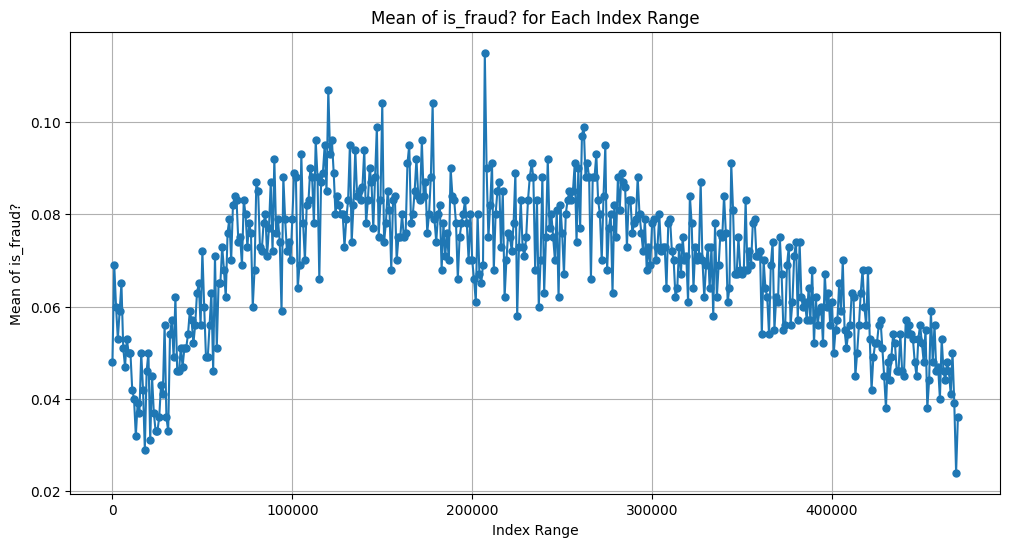

In [ ]:
# "index"の範囲ごとにデータを分割し、"is_fraud?"の平均値を計算
index_ranges = range(0, len(train_data), 1000)  # 1000ごとに範囲を分割（適宜調整）
fraud_means = []

for i in range(len(index_ranges) - 1):
    start_index = index_ranges[i]
    end_index = index_ranges[i + 1]
    subset = train_data[start_index:end_index]
    fraud_mean = subset['is_fraud?'].mean()
    fraud_means.append(fraud_mean)

# "index"の範囲ごとの平均値をプロット
plt.figure(figsize=(12, 6))
plt.plot(index_ranges[:-1], fraud_means, marker='o', linestyle='-', markersize=5)
plt.xlabel('Index Range')
plt.ylabel('Mean of is_fraud?')
plt.title('Mean of is_fraud? for Each Index Range')
plt.grid(True)
plt.show()


## merchant_state == NaN -> merchant_city == ONLINE

In [ ]:
# "merchant_state"がNaNのデータをフィルタリング
filtered_data = train_data[train_data['merchant_state'].isna()]

# "merchant_city"カラムの異なる値を取得
unique_merchant_cities = filtered_data['merchant_city'].unique()

# 異なる値を表示
print(unique_merchant_cities)


['ONLINE']
Categories (4396, object): ['Abbeville', 'Abilene', 'Abingdon', 'Abita Springs', ..., 'Zionsville',
                            'Zuni', 'Zurich', 'Zwolle']


## zip == NaN -> merchant_city == ONLINE or アメリカ国外

In [ ]:
# "zip"がNaNのデータをフィルタリング
filtered_data = train_data[train_data['zip'].isna()]

# "merchant_city"カラムの異なる値を取得
unique_merchant_cities = filtered_data['merchant_city'].unique()

# 異なる値を表示
print(unique_merchant_cities)


['Rio de Janeiro', 'ONLINE', 'Rome', 'Calgary', 'Algiers', ..., 'Muscat', 'Lisbon', 'Sao Paolo', 'Andorra La Vella', 'Moroni']
Length: 83
Categories (4396, object): ['Abbeville', 'Abilene', 'Abingdon', 'Abita Springs', ..., 'Zionsville',
                            'Zuni', 'Zurich', 'Zwolle']


In [ ]:
# isna()またはisnull()メソッドを使用して欠損値を検出
# これは各セルが欠損値の場合、Trueを返し、それ以外の場合はFalseを返します
has_nan = train_data.isna().any()

# 各カラムごとにNaNが存在するかどうかを確認
for column, has_nan_value in has_nan.iteritems():
    if has_nan_value:
        print(f"カラム '{column}' にNaNが存在します。")

# または、欠損値の総数をカウントすることもできます
total_nan_count = train_data.isna().sum().sum()
print(f"総欠損値の数: {total_nan_count}")

カラム 'merchant_state' にNaNが存在します。
カラム 'zip' にNaNが存在します。
総欠損値の数: 149908


<ipython-input-11-fdadd89d5b97>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, has_nan_value in has_nan.iteritems():


#lightGBM

## 訓練データと検証データに分割・特徴量エンジニアリング

In [ ]:
# 特徴量とターゲットの分割
X = train_data.drop(['is_fraud?'], axis=1)
y = train_data['is_fraud?']

# 訓練データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 各ホールドで特徴量の値が異なるので、test_data をコピー
test_data_copy = test_data.copy()


# 'user_card_combined' ごとの is_fraud? の平均値を計算し、新しいカラムを追加 （y_train を使用）
X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
test_data_copy['user_card_combined_mean_fraud'] = test_data_copy['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())


# 'user_card_combined' ごとに 'is_fraud?' が 1 の場合の 'amount' の平均を計算
fraud_indices = y_train[y_train == 1].index
fraud_amount_mean = X_train.loc[fraud_indices].groupby('user_card_combined')['amount'].mean().reset_index()
fraud_amount_mean.columns = ['user_card_combined', 'fraud_amount_mean']

# 'user_card_combined' ごとの 'amount' の平均を追加 （y_train を使用）
X_train = X_train.merge(fraud_amount_mean, on='user_card_combined', how='left')
X_val = X_val.merge(fraud_amount_mean, on='user_card_combined', how='left')
test_data_copy = test_data_copy.merge(fraud_amount_mean, on='user_card_combined', how='left')

# 'user_card_combined' カラムを削除
X_train.drop(['user_card_combined'], axis=1, inplace=True)
X_val.drop(['user_card_combined'], axis=1, inplace=True)
test_data_copy.drop(['user_card_combined'], axis=1, inplace=True)

# 'fraud_amount_mean' カラムを削除
X_train.drop(['fraud_amount_mean'], axis=1, inplace=True)
X_val.drop(['fraud_amount_mean'], axis=1, inplace=True)
test_data_copy.drop(['fraud_amount_mean'], axis=1, inplace=True)


# 'merchant_city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
X_train['fraud_mean_by_merchant_city'] = X_train['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
X_val['fraud_mean_by_merchant_city'] = X_val['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
test_data_copy['fraud_mean_by_merchant_city'] = test_data_copy['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())

# 'merchant_city' カラムを削除
X_train.drop(['merchant_city'], axis=1, inplace=True)
X_val.drop(['merchant_city'], axis=1, inplace=True)
test_data_copy.drop(['merchant_city'], axis=1, inplace=True)


# 'merchant_id' ごとに 'is_fraud?' の平均値を計算したDataFrameを作成
fraud_mean_by_merchant_id = y_train.groupby(X_train['merchant_id']).mean().reset_index()
fraud_mean_by_merchant_id.columns = ['merchant_id', 'fraud_mean_by_merchant_id']

# X_train に 'merchant_id' ごとの詐欺平均値をマージ
X_train = X_train.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

# X_val に 'merchant_id' ごとの詐欺平均値をマージ
X_val = X_val.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

# test_data に 'merchant_id' ごとの詐欺平均値をマージ
test_data_copy = test_data_copy.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')


# ラグ特徴量に対応する 'fraud_mean' カラムを追加
for lag in range(1, lag_window + 1):
    merchant_id_lag_col = f'merchant_id_lag{lag}'
    new_col_name = 'fraud_mean_by_' + merchant_id_lag_col

    # 'merchant_id' と 'fraud_mean_by_merchant_id' の対応付け
    X_train[new_col_name] = X_train[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
    X_val[new_col_name] = X_val[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
    test_data_copy[new_col_name] = test_data_copy[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])

    # merchant_id_lag_col カラムを削除
    X_train.drop([merchant_id_lag_col], axis=1, inplace=True)
    X_val.drop([merchant_id_lag_col], axis=1, inplace=True)
    test_data_copy.drop([merchant_id_lag_col], axis=1, inplace=True)


# 'merchant_id' カラムを削除
X_train.drop(['merchant_id'], axis=1, inplace=True)
X_val.drop(['merchant_id'], axis=1, inplace=True)
test_data_copy.drop(['merchant_id'], axis=1, inplace=True)


# 'city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
X_train['fraud_mean_by_city'] = X_train['city'].map(y_train.groupby(X_train['city']).mean())
X_val['fraud_mean_by_city'] = X_val['city'].map(y_train.groupby(X_train['city']).mean())
test_data_copy['fraud_mean_by_city'] = test_data_copy['city'].map(y_train.groupby(X_train['city']).mean())

# 'city' カラムを削除
X_train.drop(['city'], axis=1, inplace=True)
X_val.drop(['city'], axis=1, inplace=True)
test_data_copy.drop(['city'], axis=1, inplace=True)

# 数値データを float, カテゴリカルデータを category に変換
cat_cols = ['errors?', 'merchant_state', 'zip', 'mcc', 'use_chip', 'card_brand', 'card_type', 'has_chip', 'gender', 'state', 'zipcode', 'is_online', 'is_foreign']
# train_data.columnsからcat_colsに含まれないカラムを抽出してnum_colsに格納
num_cols = [col for col in X_train.columns if col not in cat_cols]

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_val[cat_cols] = X_val[cat_cols].astype('category')
test_data_copy[cat_cols] = test_data_copy[cat_cols].astype('category')

X_train[num_cols] = X_train[num_cols].astype('float')
X_val[num_cols] = X_val[num_cols].astype('float')
test_data_copy[num_cols] = test_data_copy[num_cols].astype('float')

## optuna によるハイパーパラメータチューニング

In [ ]:
def f1_eval(preds, train_data):
    y_true = train_data.get_label()
    y_pred = [1 if p >= 0.5 else 0 for p in preds]
    f1 = f1_score(y_true, y_pred)
    return 'f1_score', f1, True

In [ ]:
def objective(trial):
    # ハイパーパラメータのサーチスペースを定義
    # params = {
    #     'boosting_type': 'gbdt',
    #     'metric': 'binary_logloss',
    #     'verbose': 1,
    #     'num_iterations': trial.suggest_int('num_iterations', 100, 10000),
    #     'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
    #     'objective': 'binary',
    #     'num_leaves': trial.suggest_int('num_leaves', 7, 31),
    #     'seed': 42,
    #     'max_depth': trial.suggest_int('max_depth', 5, 9),
    #     'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 50),
    #     'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 0.9),
    #     'bagging_freq': trial.suggest_int('bagging_freq', 1, 3),
    #     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.9, 1.0),
    #     # 他のハイパーパラメータもここに追加
    # }

    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'None',

        'lambda_l1'         : trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2'         : trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),

        'force_col_wise':True,
        'random_state': 0,
        }

    # サンプルウェイトの計算
    train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
    train_dataset = lgb.Dataset(X_train, label=y_train, weight=train_weight)
    val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)


    # callbacks = [lgb.log_evaluation(1)]  # コマンドライン出力用コールバック関数
    callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数

    # モデルの学習
    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, val_dataset], num_boost_round=100, feval=f1_eval, callbacks=callbacks)

    # 検証データに対する予測
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]

    # F1スコアの計算（最大化したい指標）
    f1 = f1_score(y_val, val_pred_binary)

    return f1

# Optunaのスタディの作成
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # n_trialsは試行回数

# 最適なハイパーパラメータの表示
best_params = study.best_params
print("Best Hyperparameters:", best_params)


## classweighting

In [ ]:
# LightGBMモデルの構築
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'None',
    'verbose': 1,
    'num_iterations': 10000,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': 9,
    'min_data_in_leaf': 25,
    'bagging_fraction': 0.8894078892187123,
    'bagging_freq': 1,
    'feature_fraction': 0.9633899883834324
    # ハイパーパラメータ設定
}

train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')

train_dataset = lgb.Dataset(X_train,
                            label=y_train,
                            weight=train_weight
                            )
val_dataset = lgb.Dataset(X_val,
                          label=y_val,
                          reference=train_dataset,
                          )

callbacks = [lgb.early_stopping(stopping_rounds=10, verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数
# callbacks = [lgb.log_evaluation(1)] # コマンドライン出力用コールバック関数

model = lgb.train(params, train_dataset, valid_sets=[val_dataset],
                  callbacks=callbacks
                  )

# テストデータの予測
test_pred = model.predict(test_data_copy, num_iteration=model.best_iteration)

# 予測結果を0/1に変換してDataFrameに変換
test_pred_binary = [1 if p >= 0.5 else 0 for p in test_pred]
submission = pd.DataFrame({'0': test_data_index, '1': test_pred_binary})

# ファイルとして保存
submission.to_csv('submit_' + str(submit_id) + '.csv', header=False, index=False)


# 検証データの予測
val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# 予測結果を0/1に変換
val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]

# F1スコアの計算
f1_val = f1_score(y_val, val_pred_binary)

print("Val F1 Score:", f1_val)

## classweighting + k-fold + ensemble (f1score で earlystopping)

In [ ]:
def f1_eval(preds, train_data):
    y_true = train_data.get_label()
    y_pred = [1 if p >= 0.5 else 0 for p in preds]
    f1 = f1_score(y_true, y_pred)
    return 'f1_score', f1, True

In [ ]:
# 'is_fraud?' カラムをターゲットとして取得
X = train_data.drop(['is_fraud?'], axis=1)
y = train_data['is_fraud?']

# Stratified K-Fold Cross Validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# 各ホールドでの評価結果を保存するリスト
f1_scores = []

# 各ホールドでの予測結果を保存するリスト
test_preds = []

for fold, (train_idx, val_idx) in tqdm(enumerate(skf.split(X, y))):
    # 訓練データと検証データに分割
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # 各ホールドで特徴量の値が異なるので、test_data をコピー
    test_data_copy = test_data.copy()


    # 特徴量エンジニアリング（ここに特徴量エンジニアリングのコードを追加）

    # 'user_card_combined' ごとの is_fraud? の平均値を計算し、新しいカラムを追加 （y_train を使用）
    X_train['user_card_combined_mean_fraud'] = X_train['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
    X_val['user_card_combined_mean_fraud'] = X_val['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())
    test_data_copy['user_card_combined_mean_fraud'] = test_data_copy['user_card_combined'].map(y_train.groupby(X_train['user_card_combined']).mean())


    # 'user_card_combined' ごとに 'is_fraud?' が 1 の場合の 'amount' の平均を計算
    fraud_indices = y_train[y_train == 1].index
    fraud_amount_mean = X_train.loc[fraud_indices].groupby('user_card_combined')['amount'].mean().reset_index()
    fraud_amount_mean.columns = ['user_card_combined', 'fraud_amount_mean']

    # 'user_card_combined' ごとの 'amount' の平均を追加 （y_train を使用）
    X_train = X_train.merge(fraud_amount_mean, on='user_card_combined', how='left')
    X_val = X_val.merge(fraud_amount_mean, on='user_card_combined', how='left')
    test_data_copy = test_data_copy.merge(fraud_amount_mean, on='user_card_combined', how='left')


    # 'user_card_combined' カラムを削除
    X_train.drop(['user_card_combined'], axis=1, inplace=True)
    X_val.drop(['user_card_combined'], axis=1, inplace=True)
    test_data_copy.drop(['user_card_combined'], axis=1, inplace=True)

    # 'fraud_amount_mean' カラムを削除
    X_train.drop(['fraud_amount_mean'], axis=1, inplace=True)
    X_val.drop(['fraud_amount_mean'], axis=1, inplace=True)
    test_data_copy.drop(['fraud_amount_mean'], axis=1, inplace=True)


    # 'merchant_city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
    X_train['fraud_mean_by_merchant_city'] = X_train['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
    X_val['fraud_mean_by_merchant_city'] = X_val['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())
    test_data_copy['fraud_mean_by_merchant_city'] = test_data_copy['merchant_city'].map(y_train.groupby(X_train['merchant_city']).mean())

    # 'merchant_city' カラムを削除
    X_train.drop(['merchant_city'], axis=1, inplace=True)
    X_val.drop(['merchant_city'], axis=1, inplace=True)
    test_data_copy.drop(['merchant_city'], axis=1, inplace=True)


    # 'merchant_id' ごとに 'is_fraud?' の平均値を計算したDataFrameを作成
    fraud_mean_by_merchant_id = y_train.groupby(X_train['merchant_id']).mean().reset_index()
    fraud_mean_by_merchant_id.columns = ['merchant_id', 'fraud_mean_by_merchant_id']

    # X_train に 'merchant_id' ごとの詐欺平均値をマージ
    X_train = X_train.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

    # X_val に 'merchant_id' ごとの詐欺平均値をマージ
    X_val = X_val.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')

    # test_data に 'merchant_id' ごとの詐欺平均値をマージ
    test_data_copy = test_data_copy.merge(fraud_mean_by_merchant_id, on='merchant_id', how='left')


    # ラグ特徴量に対応する 'fraud_mean' カラムを追加
    for lag in range(1, lag_window + 1):
        merchant_id_lag_col = f'merchant_id_lag{lag}'
        new_col_name = 'fraud_mean_by_' + merchant_id_lag_col

        # 'merchant_id' と 'fraud_mean_by_merchant_id' の対応付け
        X_train[new_col_name] = X_train[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
        X_val[new_col_name] = X_val[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])
        test_data_copy[new_col_name] = test_data_copy[merchant_id_lag_col].map(fraud_mean_by_merchant_id.set_index('merchant_id')['fraud_mean_by_merchant_id'])

        # merchant_id_lag_col カラムを削除
        X_train.drop([merchant_id_lag_col], axis=1, inplace=True)
        X_val.drop([merchant_id_lag_col], axis=1, inplace=True)
        test_data_copy.drop([merchant_id_lag_col], axis=1, inplace=True)


    # 'merchant_id' カラムを削除
    X_train.drop(['merchant_id'], axis=1, inplace=True)
    X_val.drop(['merchant_id'], axis=1, inplace=True)
    test_data_copy.drop(['merchant_id'], axis=1, inplace=True)


    # 'city'ごとに'is_fraud?'の平均値を計算（y_trainを使用）
    X_train['fraud_mean_by_city'] = X_train['city'].map(y_train.groupby(X_train['city']).mean())
    X_val['fraud_mean_by_city'] = X_val['city'].map(y_train.groupby(X_train['city']).mean())
    test_data_copy['fraud_mean_by_city'] = test_data_copy['city'].map(y_train.groupby(X_train['city']).mean())

    # 'city' カラムを削除
    X_train.drop(['city'], axis=1, inplace=True)
    X_val.drop(['city'], axis=1, inplace=True)
    test_data_copy.drop(['city'], axis=1, inplace=True)


    # 数値データを float, カテゴリカルデータを category に変換
    cat_cols = ['errors?', 'merchant_state', 'zip', 'mcc', 'use_chip', 'card_brand', 'card_type', 'has_chip', 'gender', 'state', 'zipcode', 'is_online', 'is_foreign']
    # train_data.columnsからcat_colsに含まれないカラムを抽出してnum_colsに格納
    num_cols = [col for col in X_train.columns if col not in cat_cols]

    X_train[cat_cols] = X_train[cat_cols].astype('category')
    X_val[cat_cols] = X_val[cat_cols].astype('category')
    test_data_copy[cat_cols] = test_data_copy[cat_cols].astype('category')

    X_train[num_cols] = X_train[num_cols].astype('float')
    X_val[num_cols] = X_val[num_cols].astype('float')
    test_data_copy[num_cols] = test_data_copy[num_cols].astype('float')


    # LightGBMモデルの構築
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'None',

        'verbose': 1,
        'lambda_l1': 0.004712183833050388,
        'lambda_l2': 5.070611142066455e-08,
        'learning_rate': 0.01,
        'num_leaves': 248,
        'feature_fraction': 0.9229945525812634,
        'bagging_fraction': 0.9608008491478782,
        'bagging_freq': 1,
        'min_child_samples': 90,

        'force_col_wise':True,
        'random_state': 0,
        # ハイパーパラメータ設定
    }

    train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')

    train_dataset = lgb.Dataset(X_train,
                                label=y_train,
                                weight=train_weight
                                )
    val_dataset = lgb.Dataset(X_val,
                              label=y_val,
                              reference=train_dataset,
                              )


    callbacks = [
        lgb.early_stopping(stopping_rounds=500, verbose=True),
        lgb.log_evaluation(1)
        ]

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, val_dataset],
                      feval=f1_eval, # カスタムF1評価メトリック
                      num_boost_round = 10000,
                      callbacks=callbacks
                      )


    # テストデータの予測
    test_pred = model.predict(test_data_copy, num_iteration=model.best_iteration)

    # 予測結果をリストに追加
    test_preds.append(test_pred)

    # 各ホールドでの評価結果（F1スコア）を計算して保存
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]
    f1_fold = f1_score(y_val, val_pred_binary)
    f1_scores.append(f1_fold)

# 各ホールドでの評価結果（F1スコア）の平均を計算
mean_f1_score = sum(f1_scores) / num_folds
print("Mean F1 Score:", mean_f1_score)

# アンサンブル：各foldでの予測結果の平均を取る
final_test_preds = sum(test_preds) / num_folds

# 0.5の閾値でバイナリ化
final_test_preds_binary = [1 if p >= 0.5 else 0 for p in final_test_preds]

# バイナリ化した予測結果を表示または保存する
# print(final_test_preds_binary)
# もしくは、CSVファイルなどに保存する場合
final_predictions_df = pd.DataFrame({'0': test_data_index, '1': final_test_preds_binary})
final_predictions_df.to_csv('submit_' + str(submit_id) + '.csv', header=False, index=False)


In [ ]:
# アンサンブル：各foldでの予測結果の平均を取る
final_test_preds = sum(test_preds) / 4

# 0.5の閾値でバイナリ化
final_test_preds_binary = [1 if p >= 0.5 else 0 for p in final_test_preds]

# バイナリ化した予測結果を表示または保存する
# print(final_test_preds_binary)
# もしくは、CSVファイルなどに保存する場合
final_predictions_df = pd.DataFrame({'0': test_data_index, '1': final_test_preds_binary})
final_predictions_df.to_csv('submit_' + str(19) + '.csv', header=False, index=False)

## feature importance

In [ ]:
# 特徴量の重要度を取得
feature_importance = model.feature_importance(importance_type='split')  # 'split'または'gain'を選択可能

# 特徴量名を取得
feature_names = model.feature_name()

# 特徴量の重要度をDataFrameに格納
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 重要度で降順にソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 上位50の特徴量を表示
top_50_features = importance_df.head(50)
top_50_features

,Feature,Importance
3,zip,13435
4,mcc,8484
16,zipcode,8209
2,merchant_state,1596
0,amount,945
130,user_card_combined_mean_fraud,557
132,fraud_mean_by_merchant_id,474
135,fraud_mean_by_merchant_id_lag3,371
133,fraud_mean_by_merchant_id_lag1,356
143,fraud_mean_by_merchant_id_lag11,348


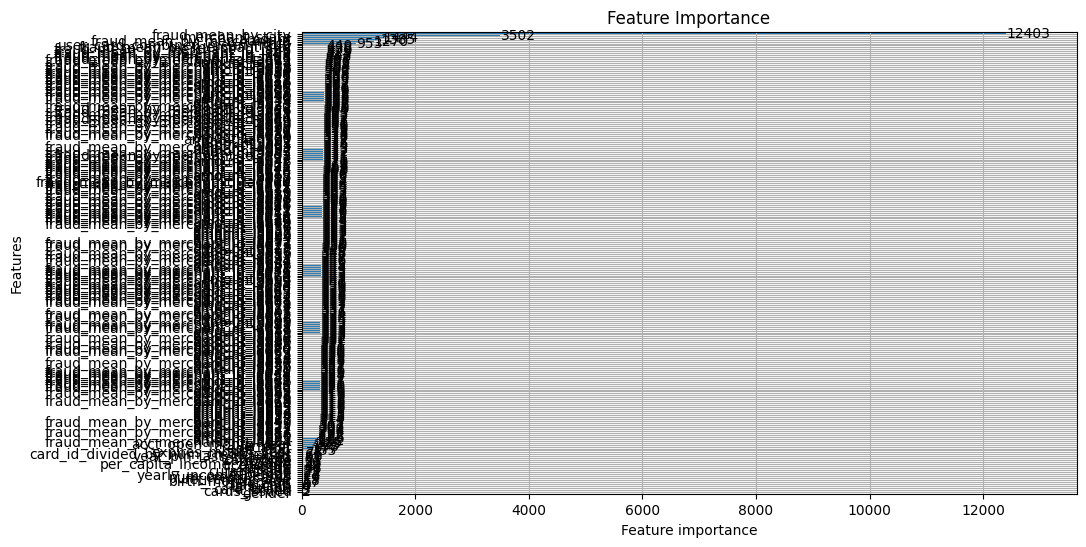

In [ ]:
# 特徴量の重要度をプロット
lgb.plot_importance(model, figsize=(10, 6), title="Feature Importance")

plt.show()

## undersampling + bagging

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import numpy as np

# バギングの回数を指定
num_bagging_iterations = 5
test_predictions = np.zeros(len(test_data))  # テストデータの予測を集約するための配列
val_predictions = np.zeros(94257)

# バギングループ
for iteration in range(num_bagging_iterations):
    # データセットの分割
    X = train_data.drop(['is_fraud?'], axis=1)
    y = train_data['is_fraud?']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # アンダーサンプリング
    fraud_data = X_train[y_train == 1]
    normal_data = X_train[y_train == 0]
    normal_data_resampled = resample(normal_data, n_samples=len(fraud_data))
    X_train_balanced = pd.concat([fraud_data, normal_data_resampled])
    y_train_balanced = pd.Series([1] * len(fraud_data) + [0] * len(normal_data_resampled))

    # LightGBMモデルの構築
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'verbose': -1
        # ハイパーパラメータ設定
    }

    train_dataset = lgb.Dataset(X_train_balanced, label=y_train_balanced)
    val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

    model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[val_dataset],
                      callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
                                 lgb.log_evaluation(-1)]
                      )

    # テストデータの予測
    test_pred = model.predict(test_data, num_iteration=model.best_iteration)
    # 検証データの予測
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # 予測結果を集約
    test_predictions += test_pred
    val_predictions += val_pred

# バギング結果の平均を取る
test_predictions /= num_bagging_iterations
val_predictions /= num_bagging_iterations

# 予測結果を0/1に変換してDataFrameに変換
test_pred_binary = [1 if p >= 0.5 else 0 for p in test_predictions]
submission = pd.DataFrame({'0': test_data_index, '1': test_pred_binary})

# ファイルとして保存
submission.to_csv('submit_7.csv', header=False, index=False)


# 予測結果を0/1に変換
val_pred_binary = [1 if p >= 0.5 else 0 for p in val_predictions]

# F1スコアの計算
f1_val = f1_score(y_val, val_pred_binary)

print("Val F1 Score:", f1_val)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.360171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[557]	valid_0's binary_logloss: 0.360104
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[559]	valid_0's binary_logloss: 0.360095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	valid_0's binary_logloss: 0.360233
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's binary_logloss: 0.358792
Val F1 Score: 0.44013909587680083


# CatBoost

In [ ]:
# 特徴量とターゲットの分割
X = train_data.drop(['is_fraud?'], axis=1)
y = train_data['is_fraud?']

# 訓練データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# merchant_stateカラムのNaN値を文字列に変換
X_train['merchant_state'] = X_train['merchant_state'].astype(str)
X_val['merchant_state'] = X_val['merchant_state'].astype(str)

# zipカラムのNaN値を文字列に変換
X_train['zip'] = X_train['zip'].astype(str)
X_val['zip'] = X_val['zip'].astype(str)

# CatBoostモデルの構築
model = CatBoostClassifier(
    iterations=10000,  # num_boost_roundに対応
    loss_function='Logloss',  # binary_loglossに対応
    eval_metric='Logloss',  # binary_loglossに対応
    verbose=0  # verboseはCatBoostのハイパーパラメータに対応
)

# カテゴリカル変数の自動エンコーディング（事前処理が不要）
cat_features = [i for i, col in enumerate(X_train.columns) if col in categorical_columns]

# 訓練データをCatBoost用のデータセットに変換
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
train_dataset = Pool(X_train, label=y_train, cat_features=cat_features, weight=train_weight)

# 検証データをCatBoost用のデータセットに変換
val_dataset = Pool(X_val, label=y_val, cat_features=cat_features)

# モデルのトレーニング
model.fit(train_dataset, eval_set=val_dataset, early_stopping_rounds=100, verbose_eval=True)

# モデルをファイルに保存
model.save_model('catboost_model.cbm')


# merchant_stateカラムのNaN値を文字列に変換
test_data['merchant_state'] = test_data['merchant_state'].astype(str)

# zipカラムのNaN値を文字列に変換
test_data['zip'] = test_data['zip'].astype(str)

# テストデータの予測
test_pred = model.predict(test_data, prediction_type='Probability')[:, 1]

# 予測結果を0/1に変換してDataFrameに変換
test_pred_binary = [1 if p >= 0.5 else 0 for p in test_pred]
submission = pd.DataFrame({'0': test_data_index, '1': test_pred_binary})

# ファイルとして保存
submission.to_csv('submit_7.csv', header=False, index=False)


# 検証データの予測
val_pred = model.predict(X_val, prediction_type='Probability')[:, 1]

# 予測結果を0/1に変換
val_pred_binary = [1 if p >= 0.5 else 0 for p in val_pred]

# F1スコアの計算
f1_val = f1_score(y_val, val_pred_binary)

print("Val F1 Score:", f1_val)